In [549]:
import requests
import zillow
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
import time                                   # I am blocked by zillow.com, so I have to use it.
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer   # sklearn --- primer machine learning package
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.patches as mpatches
import re

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36'
}

Ziyi Zhou and Zihan Wang

# Background

The price of houses is always hot, and it is unlikely that this will change in the near future. There are many factors affecting the price of houses. When choosing a house, what factors do people pay more attention to? The price of a house can change dramatically in a short period of time. How to predict house prices is a difficult problem. However, with the popularity of data, we have enough data to predict house prices. We want to know what factors can affect the price of a house more. Therefore, we hope to find a website for home buying and selling to collect timely information and data to solve this problem.

Zillow.com is a website that provides free real estate valuation services. Founded in 2006, it mainly provides various real estate information query services to citizens. Users can zoom the satellite map directly on the webpage to find the target, or search by zip code and street.

# Data Extraction

In [484]:
all_feature_list = ['Year built:','Lot:','Type:','HOA:', 'Price/sqft:','Cooling:','Parking:','Heating:']
all_feature_list

['Year built:',
 'Lot:',
 'Type:',
 'HOA:',
 'Price/sqft:',
 'Cooling:',
 'Parking:',
 'Heating:']

In [285]:
# We want to compare all the house price among different states. So here is the function:
def get_data(state):
    """
    The input of the function is the string of each state and the output is a dataframe with 13 columns.
    "value": The price of the house; 
    "address": The address of the house;
    "bedroom","bathroom": The number of bedrooms and bathrooms;
    "area": The area of the house; 
    Others are the features and facts of the house. 
    Because zillow.com only shows us twenty pages so I can only obtain 800 pieces of data for each state.
    """
    dataset = pd.DataFrame()
    for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        url = 'https://www.zillow.com/' + state +  '/' + str(i) + '_p/'
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, 'lxml')

        diction={}
        web = [list2['href'] for list2 in soup.find_all('a', attrs={'class': 'list-card-link'})]
        web = list(set(web))
        for k in range(8):
            diction[all_feature_list[k]] = []

        value, addr, bed, bath, sqft =[],[],[],[],[]
        for p in web:
            res0 = requests.get(p, headers=headers)
            soup0 = BeautifulSoup(res0.text, 'lxml')
            all_value = [value.text for value in soup0.find_all('span', attrs={'class': 'ds-body ds-home-fact-value'})]
            all_feature = [feature.text for feature in soup0.find_all('span', attrs={'class': 'ds-standard-label ds-home-fact-label'})]

            for q in range(8):
                try:
                    ind = all_feature.index(all_feature_list[q])
                    diction[all_feature_list[q]] += [all_value[ind]]
                except:
                    diction[all_feature_list[q]] += [None]

            try:
                value.append(soup0.find_all('span', attrs={'class': 'ds-value'})[0].text)
            except:
                value.append(None)
            try:
                addr.append(soup0.find_all('h1', attrs={'class': 'ds-address-container'})[0].text) 
            except:
                addr.append(None)
            try:
                bed.append(int(soup0.find_all('span', attrs={'class': 'ds-bed-bath-living-area'})[0].text.split('bd')[0]))
            except:
                bed.append(None)
            try:    
                bath.append(int(soup0.find_all('span', attrs={'class': 'ds-bed-bath-living-area'})[1].text.split('ba')[0]))
            except:
                bath.append(None)

            area0=''
            try:
                for string in soup0.find_all('span', attrs={'class': 'ds-bed-bath-living-area'})[2].text.split('sqft')[0].split(','):
                    area0 += string
                sqft.append(int(area0))
            except:
                sqft.append(None)
                
        data = {'value':value,'address':addr,'bedroom':bed,'bathroom':bath,'area':sqft,'Year built':diction['Year built:'],\
                'Lot':diction['Lot:'],'Type':diction['Type:'],'HOA':diction['HOA:'],'Price/sqft':diction['Price/sqft:'],\
                'Cooling':diction['Cooling:'],'Parking':diction['Parking:'],'Heating':diction['Heating:']}
        dataset = dataset.append(pd.DataFrame(data))
        time.sleep(10)   # I have to do so, nor zillow.com blocks me.
    return dataset 

In [297]:
# In this part, I finish the code for extracting data
# Though for each state there are hundred thousand of houses for sale, we can only obtain 20 pages, about 800 houses in total.
# We only consider eastern states and western states. Use the function above, we can get data of any state. 
# We think eastern states and western states are popular so we only obtain data of them.

east = ['CT','MA','MD','NY','PA','SC','VA','ME','VT','NH','RI','NJ','DE','WV','NC','GA','AL'] 
west = ['CA','OR','WA','AK','MO','ID','MT','NV','UT','WY']

for state in [east[10]]:                             # Here is only an example. It should be east+west
    data_com = get_data(state)
    time.sleep(10)                                   # Zillow.com will block your request if you send them too quickly.
    if len(data_com)==0:
        print(state+'error')
        break
    else:
        data_com.to_csv(state + 'price_data.csv')
        print(state+'done')

RIdone


# Data Analysis

Given the dataset, we want to obtain the summary of the data. Apparently, there are many missing values and unmatched values. So, firstly, we had to clear the data and transform the data from type(str) to what we want. 

In [340]:
states = east + west
df = pd.DataFrame()
for state in states:
    data_state = pd.read_csv('data/'+ state + 'price_data.csv')
    data_state = data_state.drop(columns = ['Unnamed: 0'])
    data_state['state'] = [state]*len(data_state)
    df = df.append(data_state)

In [342]:
df.to_csv('data_all.csv')

In [348]:
# Let me check the data. It is right but it is still need clearing.
df.head()   #There are 21600 rows.

,Unnamed: 0,value,address,bedroom,bathroom,area,Year built,Lot,Type,HOA,Price/sqft,Cooling,Parking,Heating,state
0,0,"$30,000,000","591 Riversville Rd, Greenwich, CT 06831",7.0,13.0,13343.0,1775.0,17.2 acres,Single Family,NaN,"$2,248",Central,6 spaces,Other,CT
1,1,"$16,500,000","1125 Pequot Ave, Southport, CT 06890",7.0,11.0,11760.0,2015.0,3.44 acres,Single Family,NaN,"$1,403",Central,4 spaces,Forced air,CT
2,2,"$289,000","749 Durham Rd, Guilford, CT 06437",3.0,3.0,1678.0,1963.0,1 acre,Single Family,NaN,$172,Other,2 spaces,Baseboard,CT
3,3,"$1,399,000","98 North Ave, Westport, CT 06880",4.0,4.0,3835.0,2019.0,1 acre,Single Family,NaN,$365,Central,2 spaces,Forced air,CT
4,4,"$235,000","98 Acacea Ct, Middletown, CT 06457",3.0,2.0,1856.0,1965.0,0.46 acres,Single Family,NaN,$127,None,1 space,Baseboard,CT


## Data exploration

In [398]:
# First, transform all the numerical data into the type of integral.
df = pd.read_csv('data_all.csv')
value0,Lot0,PS0,Parking0 = [],[],[],[]
for i in range(len(df)):
    try:
        value = df.iloc[i]['value'].split('$')[1].split(',')
        comt0 = ''
        for j in value:
            comt0 += j
        value0.append(int(comt0))
    except:
        value0.append(None)
    try:    
        if df.iloc[i]['Lot'].split(' ')[1] in'acres':
            Lot0.append(float(df.iloc[i]['Lot'].split(' ')[0]))
        elif df.iloc[i]['Lot'].split(' ')[1] == 'sqft':
            Lot = df.iloc[i]['Lot'].split(' ')[0]
            comt2=''
            for j in Lot:
                comt2 += j
            Lot0.append(float(comt2)/43560)
        else:
            Lot0.append(None)
    except:
        Lot0.append(None)
    try:
        PS = df.iloc[i]['Price/sqft'].split('$')[1].split(',')
        comt1 = ''
        for j in PS:
            comt1 += j
        PS0.append(int(comt1))
    except:
        PS0.append(None)
    try:
        Parking = df.iloc[i]['Parking'].split(' space')[0]
        Parking0.append(int(Parking))
    except:
        Parking0.append(1)

In [540]:
num_data = {'num_price':value0,'num_Lot':Lot0,'num_PS0':PS0,'num_Parking':Parking0}
num_table = pd.DataFrame(num_data)
fresh_data = pd.concat([num_table,df], axis = 1)
#fresh_data.to_csv('new_data.csv')

In [541]:
# We drop the charactor HOA because too much missing value (about 90%). 
# Other missing values are sparse but if we drop all the rows with missing values, there are half of data left.
# Hence, we don't do it
fresh_data = fresh_data.drop(['HOA','Unnamed: 0','value','Lot','Price/sqft','Parking'],axis = 1)
fresh_data = fresh_data.drop([4803,3141,2966],axis = 0)

In [542]:
# Here is the data we finally use. 
fresh_data.head()

,num_price,num_Lot,num_PS0,num_Parking,address,bedroom,bathroom,area,Year built,Type,Cooling,Heating,state
0,30000000.0,17.20,2248.0,6,"591 Riversville Rd, Greenwich, CT 06831",7.0,13.0,13343.0,1775.0,Single Family,Central,Other,CT
1,16500000.0,3.44,1403.0,4,"1125 Pequot Ave, Southport, CT 06890",7.0,11.0,11760.0,2015.0,Single Family,Central,Forced air,CT
2,289000.0,1.00,172.0,2,"749 Durham Rd, Guilford, CT 06437",3.0,3.0,1678.0,1963.0,Single Family,Other,Baseboard,CT
3,1399000.0,1.00,365.0,2,"98 North Ave, Westport, CT 06880",4.0,4.0,3835.0,2019.0,Single Family,Central,Forced air,CT
4,235000.0,0.46,127.0,1,"98 Acacea Ct, Middletown, CT 06457",3.0,2.0,1856.0,1965.0,Single Family,None,Baseboard,CT


First of all, I compute the mean of house price in each state and get a bar plot.

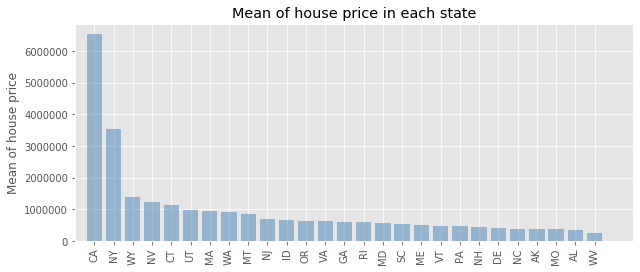

In [543]:
mean_price = fresh_data.groupby('state').agg({'mean'})['num_price'].sort_values(by = 'mean',ascending = False)
plt.figure(figsize = (10,4))
words = list(mean_price.index)
n = len(words)
x_pos = np.arange(n)
y = list(mean_price['mean'])

plt.bar(x_pos, y, align='center',color='steelblue',alpha=.5)
plt.xlim(-1,n+1)
plt.xticks(x_pos, words, rotation=90)
plt.ylabel('Mean of house price')
plt.title('Mean of house price in each state')


# save this figure   
# plt.savefig('skill set of STAT.png')
    
plt.show()

Obviouly, as is shown in the bar plot, the mean of house price in California is much higher than other states. The house price in New York is also very high. The reason is simple: they are the most advanced and wealthy states in US. But is it true that house price in CA is much higher than that in NY? We need further study.

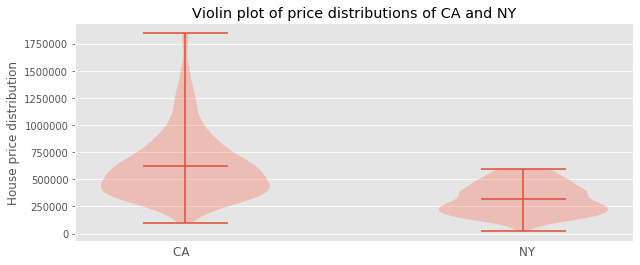

In [544]:
# We have to drop those luxury real estate in this part.
plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
CA_L = fresh_data[fresh_data['state']=='CA']['num_price'].quantile(0.75)
NY_L = fresh_data[fresh_data['state']=='NY']['num_price'].quantile(0.75)
CA = [x for x in fresh_data[fresh_data['state']=='CA']['num_price'].dropna().tolist() if x<CA_L ]
NY = [x for x in fresh_data[fresh_data['state']=='NY']['num_price'].dropna().tolist() if x<NY_L ]



violin_parts = plt.violinplot( [CA,NY], showmeans=True)    
for pc in violin_parts['bodies']:
    pc.set_facecolor('tomato')
    
plt.xlabel('CA' + ' '*85 + 'NY' )
plt.ylabel('House price distribution')
plt.xticks([])
plt.title('Violin plot of price distributions of CA and NY')
#plt.savefig('salary_violinplot.png')
plt.show()

Notice that, after we drop the 25% top expensive houses, we can get the distributions of house price in CA and NY. Notice that CA has much more houses whose price are millions of dollars while New York doesn't. The median of house price in CA is about 600000 while it is 300000 in NY. We conclude that people living in CA may pay more to get their own house.

What makes this phenomenon? For the houses, are there any difference of houses among different states? Next, we will figure them out. 

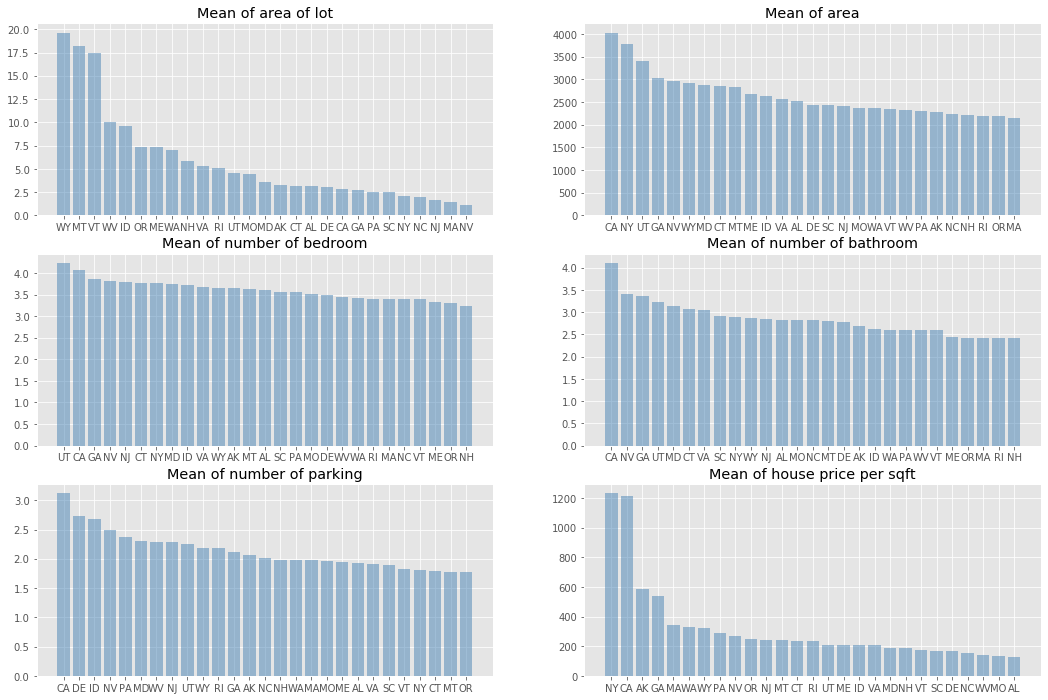

In [545]:
mean_Lot = fresh_data.groupby('state').agg({'mean'})['num_Lot'].sort_values(by = 'mean',ascending = False)
mean_parking = fresh_data.groupby('state').agg({'mean'})['num_Parking'].sort_values(by = 'mean',ascending = False)
mean_area = fresh_data.groupby('state').agg({'mean'})['area'].sort_values(by = 'mean',ascending = False)
mean_bedroom = fresh_data.groupby('state').agg({'mean'})['bedroom'].sort_values(by = 'mean',ascending = False)
mean_bathroom = fresh_data.groupby('state').agg({'mean'})['bathroom'].sort_values(by = 'mean',ascending = False)
mean_PS = fresh_data.groupby('state').agg({'mean'})['num_PS0'].sort_values(by = 'mean',ascending = False)
fig,a = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

words1 = list(mean_Lot.index)
words5 = list(mean_area.index)
words2 = list(mean_parking.index)
words3 = list(mean_bedroom.index)
words4 = list(mean_bathroom.index)
words6 = list(mean_PS.index)

y1 = list(mean_Lot['mean'])
y2 = list(mean_parking['mean'])
y3 = list(mean_bedroom['mean'])
y4 = list(mean_bathroom['mean'])
y5 = list(mean_area['mean'])
y6 = list(mean_PS['mean'])

a[0][0].bar(words1, y1, align='center',color='steelblue',alpha=.5)
a[0][0].set_title('Mean of area of lot')

a[0][1].bar(words5, y5, align='center',color='steelblue',alpha=.5)
a[0][1].set_title('Mean of area')

a[2][0].bar(words2, y2, align='center',color='steelblue',alpha=.5)
a[2][0].set_title('Mean of number of parking')

a[2][1].bar(words6, y6, align='center',color='steelblue',alpha=.5)
a[2][1].set_title('Mean of house price per sqft')

a[1][0].bar(words3, y3, align='center',color='steelblue',alpha=.5)
a[1][0].set_title('Mean of number of bedroom')

a[1][1].bar(words4, y4, align='center',color='steelblue',alpha=.5)
a[1][1].set_title('Mean of number of bathroom')

# save this figure   
# plt.savefig('skill set of STAT.png')
    
plt.show()

We can observe that there is no obvious difference for number of parking, bedroom and bathroom. But, the area of Lot has a flunctuation. We want to study more about "area". Because the area of the house is the basic charactor, so maybe "Price/sqft" is a better charactor.

Here is a weird problem. Notice that for CA and NY, the mean of area and house price per sqft are similar while the price has a huge difference, why?

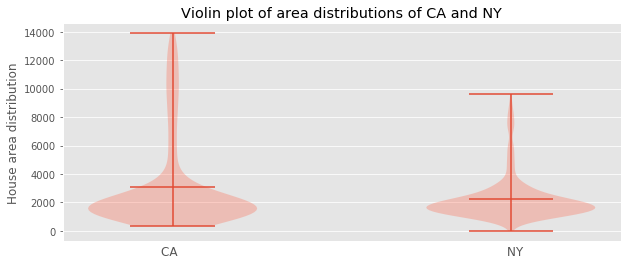

In [571]:
plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
CA_L = fresh_data[fresh_data['state']=='CA']['area'].quantile(0.95)
NY_L = fresh_data[fresh_data['state']=='NY']['area'].quantile(0.95)
CA = [x for x in fresh_data[fresh_data['state']=='CA']['area'].dropna().tolist() if x<CA_L ]
NY = [x for x in fresh_data[fresh_data['state']=='NY']['area'].dropna().tolist() if x<NY_L ]

violin_parts = plt.violinplot( [CA,NY], showmeans=True)    
for pc in violin_parts['bodies']:
    pc.set_facecolor('tomato')
    
plt.xlabel('CA' + ' '*85 + 'NY' )
plt.ylabel('House area distribution')
plt.xticks([])
plt.title('Violin plot of area distributions of CA and NY')
#plt.savefig('salary_violinplot.png')
plt.show()

We may conclude that the house prices in CA and NY are exactly higher than others, and the prices for per sqft are also higher. Compared with each other, actually they have similar house price. Because CA has more luxury real estates, such as Beverly Hills, they make the mean of house price become higher. 

What about the year ?

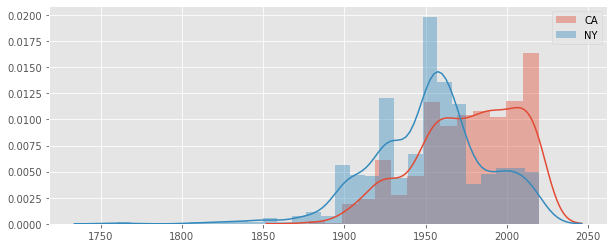

In [569]:
plt.figure(figsize = (10,4))
CA,NY = [],[]
for i in fresh_data[fresh_data['state']=='CA']['Year built'].tolist():
    try:
        CA.append(int(i))
    except:
        continue
for i in fresh_data[fresh_data['state']=='NY']['Year built'].tolist():
    try:
        NY.append(int(i))
    except:
        continue
sns.distplot(CA, label='CA')
sns.distplot(NY, label='NY')
plt.legend()

Here, we know that for those house for sale, houses in CA are newer than those in NY. Thank for the development of those advanced tech, such as Internet, CA have made a great development these years.

To figure out what factors can affect the price of a house,we need some more tools.

## Map

In this section, we want to get the general distribution of each house. Here we only consider CA and NY.

In [648]:
import geocoder
import geopy
import folium
from folium import plugins

In [652]:
data = pd.read_csv('data_clean.csv')

df1 = data.loc[:,['value','address','state']]
df2 = df1[df1.state == "CA"]
df3 = df1[df1.state == "NY"]
data_CANY = pd.concat([df2,df3])
data_CANY = data_CANY.reset_index(drop=True)

In [653]:
icon = []
for i in range(len(data_CANY)):
    if data_CANY.iloc[i]['value']<100000:
        icon.append(1)
    elif data_CANY.iloc[i]['value']<=500000:
        icon.append(2)
    elif data_CANY.iloc[i]['value']<=1000000:
        icon.append(3)
    else:
        icon.append(4)
icon = pd.DataFrame({'icon':icon})
data_CANY = pd.concat([data_CANY,icon],axis=1) 

In [654]:
address_latlng,latlng = [],[]
for i in data_CANY.address:
    address_latlng = geocoder.osm(i)
    latlng.append([address_latlng.lat,address_latlng.lng])
df100 = pd.DataFrame(latlng)
df100 = df100.rename(columns = {0:"latitude",1:"longitude"})
data_CANY = pd.concat([data_CANY,df100],axis=1)
data_CANY.rename(columns = {0:"latitude",1:"longitude"})
data_CANY = data_CANY.dropna()
mapds = folium.Map(location=[34,-117], zoom_start=4)
for i in data_CANY.itertuples():
    folium.Marker(location = [i.latitude,i.longitude],popup = i.value,tooltip = "click",
                  icon = plugins.BeautifyIcon(number = i.icon, border_color = "blue",
                                              border_width = 1,
                                              text_color = "red",
                                              inner_icon_style = "margin-top:0px;")).add_to(mapds)
                 
mapds

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=9921+Flora+Vista+St+UNIT+5%2C%C2%A0Bellflower%2C+CA+90706&format=jsonv2&addressdetails=1&limit=1 (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x0000016484BF7898>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=5.0)'))


Notice that, in CA, most of houses are located at Bay area and Los angles area while in NY, houses are located at New York City and some other large cities.

# Model Analysis

In [575]:
import statsmodels.api as sm

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


After plotting the data, we would like to use machine learning method to predict the price of houses. The regression methods we chose are that linear regression, KNN，SVR and DecisionTree.

We split data into trainging data and test data. The proportion of trainging data and test data is 2:1. First, since the data scratched from websites, we need to clean data first. For quantity variables, we need to get the numeric variables. And for quality variables, we group some similar levels for variables Cooling and Heating. And for parking variables, we regard it as quantity variable to represent the number of parking. Here is the function for cleaning data. After cleaning the data, we read our data.

In [ ]:
pd.set_option('display.max_columns',None)


def clean():
    #read data
    data=pd.read_csv("data.csv",index_col=0)
    
    #data information
    data.info()
    data.head()
    #rename index
    data.index=range(len(data))
    
    #repalce No Data to np.nan
    data.replace("No Data",np.nan,inplace=True)
    
    #Value：remove '$' and ','  
    data['value']=data['value'].str.replace("[$,]","")
    data['value']=data['value'].astype(float)
    
    
    #Year:  change to float type
    data['Year built'][:10]
    data['Year built']=data['Year built'].astype(float)
    
    #Lot: change to the same unit
    #1 acre=43560 sqrf
    tmp=np.where(data['Lot'].str.contains("acre"),43560,1)
    
    #remove words
    data['Lot']=data['Lot'].str.replace("[a-zA-Z,]","")
    #change to float type
    data['Lot']=data['Lot'].astype(float)
    
    #change to the same unit
    data['Lot']=data['Lot']*tmp
    
    
    #Price/sqft：remove '$' and ','
    data['Price/sqft']=data['Price/sqft'].str.replace("[$,]","")
    data['Price/sqft']=data['Price/sqft'].astype(float)
    
    #Parking: change to quantity variable
    tmp=data['Parking'].str[:1]
    tmp=tmp.str.replace("[A-Za-z]","1")
    data['Parking']=tmp.astype(float)
    
    #Cooling: combine similar levels
    data['Cooling'] = data['Cooling'].str.replace("Central.+","Central")
    data['Cooling'] = data['Cooling'].str.replace("Evaporative.+","Evaporative")
    data['Cooling'] = data['Cooling'].str.replace("Geothermal.+","Geothermal")
    data['Cooling'] = data['Cooling'].str.replace("Other.+","Other")
    data['Cooling'] = data['Cooling'].str.replace("Solar.+","Solar")
    data['Cooling'] = data['Cooling'].str.replace("Wall.+","Wall")
    
    #Heating: combine similar levels
    data['Heating'] = data['Heating'].str.replace("Baseboard.+","Baseboard")
    data['Heating'] = data['Heating'].str.replace("Electric.+","Electric")
    data['Heating'] = data['Heating'].str.replace("Heat.+","Heat Pump")
    data['Heating'] = data['Heating'].str.replace("Oil.+","Oil")
    data['Heating'] = data['Heating'].str.replace("Forced.+","Forced Air")
    data['Heating'] = data['Heating'].str.replace("Radiant.+","Radiant")
    data['Heating'] = data['Heating'].str.replace("Stove.+","Stove")
    data['Heating'] = data['Heating'].str.replace("(Other.+)|(Coal)|(Solar)|(Wood.+)|(Solar)|(Geothermal)|(Propane.+)","Other")
    data['Heating'] = data['Heating'].str.replace("Gas.+","Gas")
    data['Heating'] = data['Heating'].str.replace("Other.+","Other")
    
    #remove NA (except HOA)
    data=data[~(data.drop(columns='HOA').isna().any(axis=1))]

    #Output new data
    data.to_csv("data_new.csv",index=False)


#if __name__=="__main__":
    #clean()

## Linear regression model

First, we use linear regression model to find the factors which can affect the price of houses more. For selecting for variables, we drop three variables, price/sqft, address and HOA(HOmeowners Association). The reasons are that we group houses by state instead of address and HOA has too many missing values. And for price/sqft, if we get this varible, we can get our result by multipying area. It will be no sense for predicting total value and preice/sqft is high correlated with area and value, therefore, we decide to drop it. For the rest of variables, the quality variables includes type, cooling,heating and state. And the quantity variables includes value, bedroom, bathroom, area year bulit, lot and parking. Here are the descriptions of variables below:  
*  Value: The total price of each house.  
*  Bedroom: The number of bedroom.  
*  Bathroom: The number of bathroom.  
*  Area: The area of the house, unit is sqft.  
*  Lot: The area of lot, unit is sqft.  
*  Type: The type of the house, two levels: single family and townhouse.  
*  Cooling: The main way for cooling of the house, eight levels: Central, EvaporativeGeotherma, None, Other,Refrigeration,Solar,Wall.
*  Heating: The main way for heating of the house, eleven level: Baseboard, Electric, Forced Air, Gas, Heat Pump, None, Oil, Other,       Radiant, Stove, Wall.  
*  Parking: The number of cars to park.  
*  State: State of the house.

In [595]:
data = pd.read_csv('data_clean.csv')
X = data.drop('value', axis = 1)
y = data['value']
y = np.log(y)      # The scale of price is much larger than other variables.

X = data[['bedroom',"bathroom",'area','Year built']]
intercept = pd.DataFrame([1]*len(y),columns = ["intercept"])
Type = pd.get_dummies(data['Type'])
Cooling = pd.get_dummies(data['Cooling'])
Heating = pd.get_dummies(data['Heating'])
state = pd.get_dummies(data['state'])
X = pd.concat([intercept,X, Type, Cooling, Heating, state],axis = 1)

model_1 = sm.OLS(y,X)
model_1_res = model_1.fit()

model_1_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     628.0
Date:                Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:10:25   Log-Likelihood:                -9951.4
No. Observations:               13166   AIC:                         2.000e+04
Df Residuals:                   13117   BIC:                         2.037e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         6.3854      0.151     42.421      0.000       6.090       6.680
bedroom          -0.0025      0.006     -0.437      0.662      -0.014       0.009
bathroom          0.3261      0.005     71.507      0.000       0.317       0.335
area           3.948e-05   2.27e-06     17.398      0.000     3.5e-05    4.39e-05
Year built        0.0003      0.000      2.365      0.018    5.31e-05       0.001
Single Family     3.2957      0.076     43.533      0.000       3.147       3.444
Townhouse         3.0897      0.077     39.974      0.000       2.938       3.241
Central           0.7125      0.048     14.778      0.000       0.618       0.807
Evaporative       0.6542      0.085      7.681      0.000       0.487       0.821
Geothermal        1.2096      0.131      9.262      0.000       0.954       1.466
None              0.5217      0.048     10.943      0.000       0.428       0.615
Other             0.6092      0.051     11.970      0.000       0.509       0.709
Refrigeration     1.4304      0.191      7.503      0.000       1.057       1.804
Solar             0.5969      0.231      2.579      0.010       0.143       1.050
Wall              0.6509      0.053     12.357      0.000       0.548       0.754
Baseboard         0.6334      0.028     22.498      0.000       0.578       0.689
Electric          0.5908      0.051     11.665      0.000       0.492       0.690
Forced Air        0.6387      0.027     23.824      0.000       0.586       0.691
Gas               0.6173      0.050     12.326      0.000       0.519       0.715
Heat Pump         0.6757      0.031     21.800      0.000       0.615       0.736
None              0.2329      0.194      1.202      0.229      -0.147       0.612
Oil               0.3336      0.061      5.427      0.000       0.213       0.454
Other             0.6158      0.029     21.010      0.000       0.558       0.673
Radiant           0.8269      0.039     21.425      0.000       0.751       0.903
Stove             0.5467      0.053     10.258      0.000       0.442       0.651
Wall              0.6735      0.060     11.281      0.000       0.556       0.791
AK                0.2664      0.031      8.588      0.000       0.206       0.327
AL               -0.2500      0.023    -10.716      0.000      -0.296      -0.204
CA                0.9873      0.022     44.313      0.000       0.944       1.031
CT                0.2670      0.022     12.289      0.000       0.224       0.310
DE                0.0696      0.023      2.995      0.003       0.024       0.115
GA               -0.1315      0.022     -6.003      0.000      -0.174      -0.089
ID                0.3681      0.025     14.786      0.000       0.319       0.417
MA                0.7251      0.025     28.972      0.000       0.676       0.774
MD                0.1566      0.023      6.697   

We use logarithm transformation to our response variable, because the difference of price of houses are really large. After fitting the linear regression model, all the variables are statitically significant except bedroom. The reason might be the high correlation between bedroom and bathroom. It is common that a house has many bedrooms with many bathrooms. Therefore, we only keep one of these two variables. And for output, there is two warnings which is caused mulicollinearity problem. It is true that our variables have the high correlation. Mulicollinearity problem may cause the bias of predication. And we also check the assumptions of linearity.

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted')]

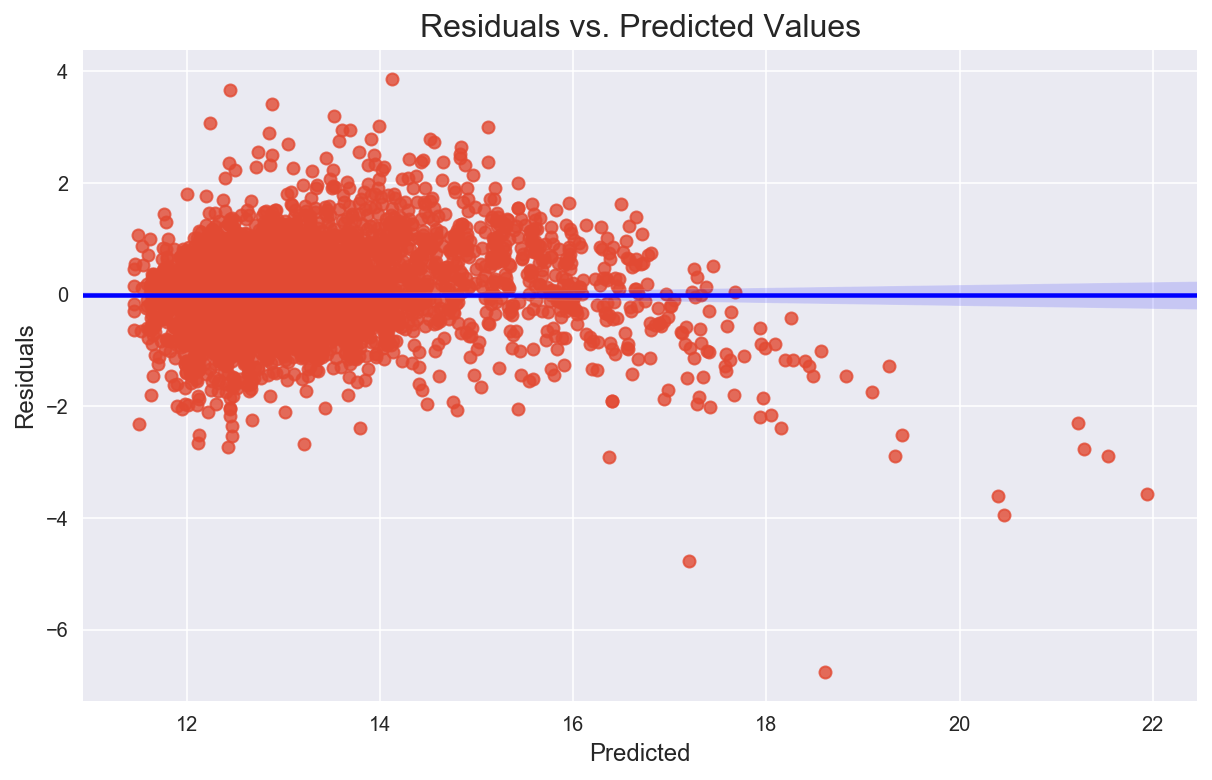

In [642]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (10,6)
fitted_vals = model_1_res.predict()
resids = model_1_res.resid

fig, ax = plt.subplots(1,1)
    

sns.regplot(x=fitted_vals, y=resids,  ax=ax, line_kws={'color': 'blue'})
ax.set_title('Residuals vs. Predicted Values', fontsize=16)
ax.set(xlabel='Predicted', ylabel='Residuals')

Notice that for the expensive house, the residuals become negative, which means our prediction is lower than actual price. Our assumption is that for those luxury house, because of the lack of charactor in our dataset, there are some "Premium" that our model can not explain for. 

Actually, our aim is to predict the price of the house, so we need to test our model.

In [584]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

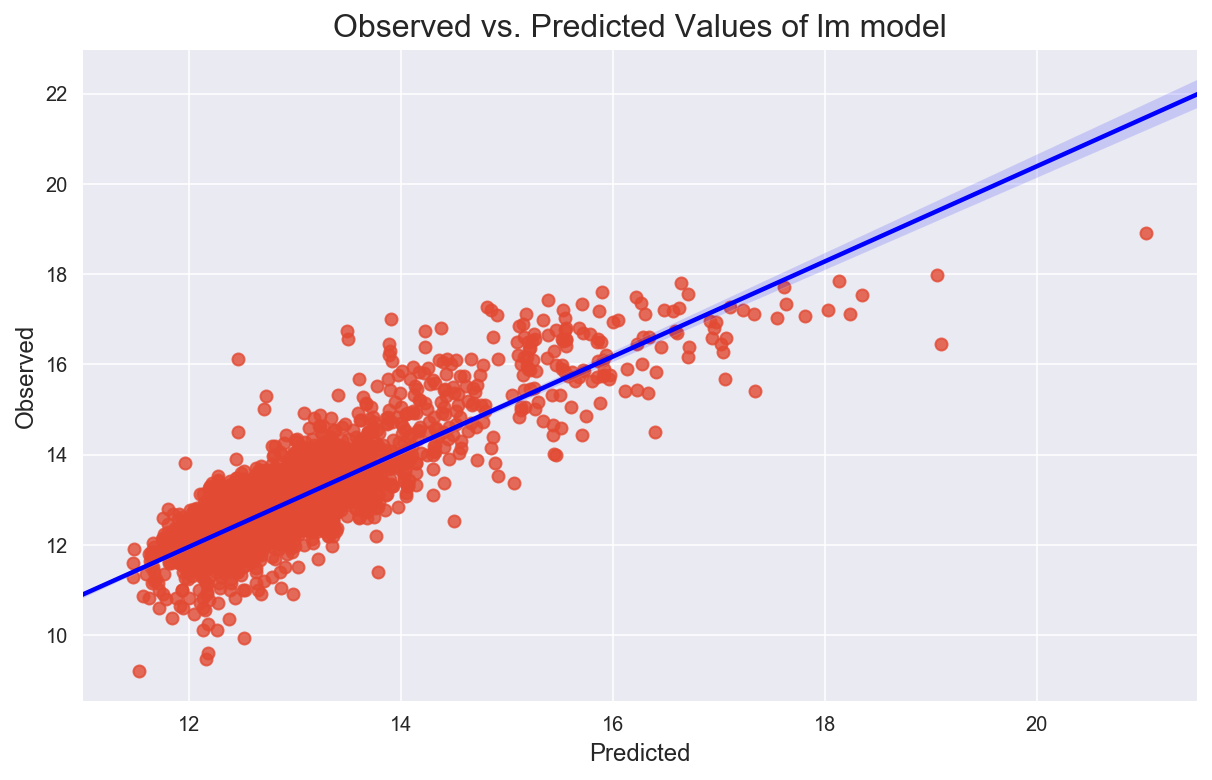

In [641]:
model_1_tr = sm.OLS(y_train,X_train)
model_1_tr_res = model_1_tr.fit()

fitted_vals = model_1_tr_res.predict(X_test)

fig,ax = plt.subplots(1,1)
    
sns.regplot(x=fitted_vals, y=y_test, ax=ax,line_kws={'color': 'blue'})
ax.set_title('Observed vs. Predicted Values of lm model', fontsize=16)
ax.set(xlabel='Predicted', ylabel='Observed')

In [617]:
print('The MSE of the model is '+str(mean_squared_error(fitted_vals, y_test)))

The MSE of the model is 0.2703923384354733


From the Residuals vs. Predicted Values plot, it shows that the linear regression model does not violate linearity and homoscedasticity. And from the Observed vs. Predicted Values plot, it shows that the linear regression model can predict the price of houses well. But, because of the mulicollinearity problem, furthermore, we want to try other mechine learning methods to predict the price of houses.

## K-Nearest Neighbors Algorithm

Then, we select KNN method to predict the price of house. 

A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data.

Text(0.5, 1.0, 'MSE with the number of neighbour')

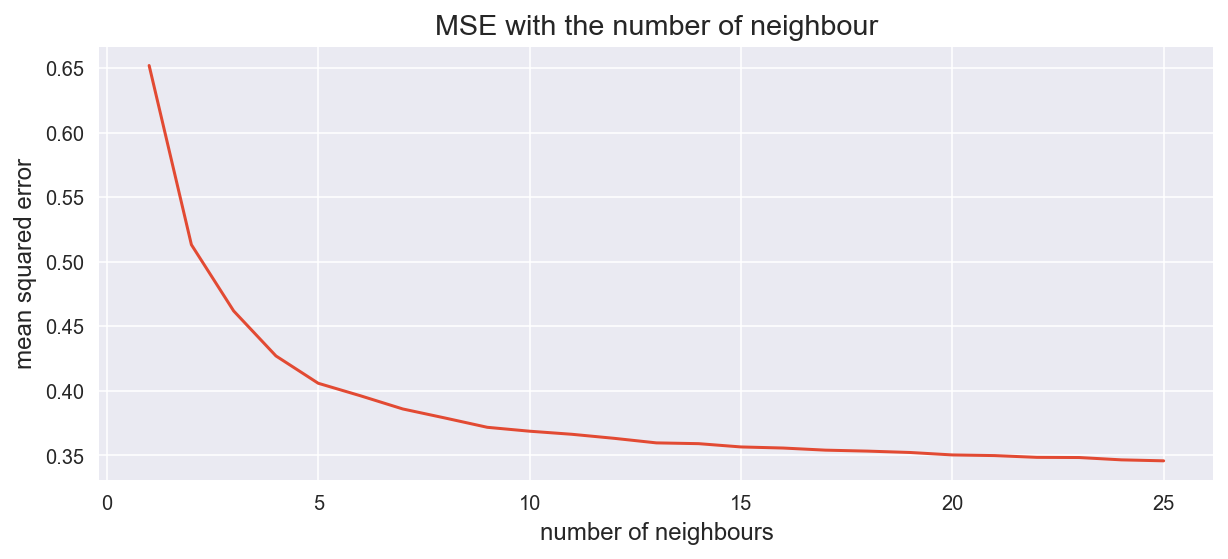

In [615]:
i = list(range(10))
x1 = list(range(1,26))
y1 = []
y2 = []
for i in list(range(25)):
    model = neighbors.KNeighborsRegressor(i+1).fit(X_train, y_train)
    pre = model.predict(X_test)
    y1.append(mean_squared_error(pre, y_test))
    
plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
plt.plot(x1,y1)
plt.xlabel('number of neighbours')
plt.ylabel('mean squared error')
plt.title('MSE with the number of neighbour')

Here, the larger k is, the better model is. We choose 25.

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

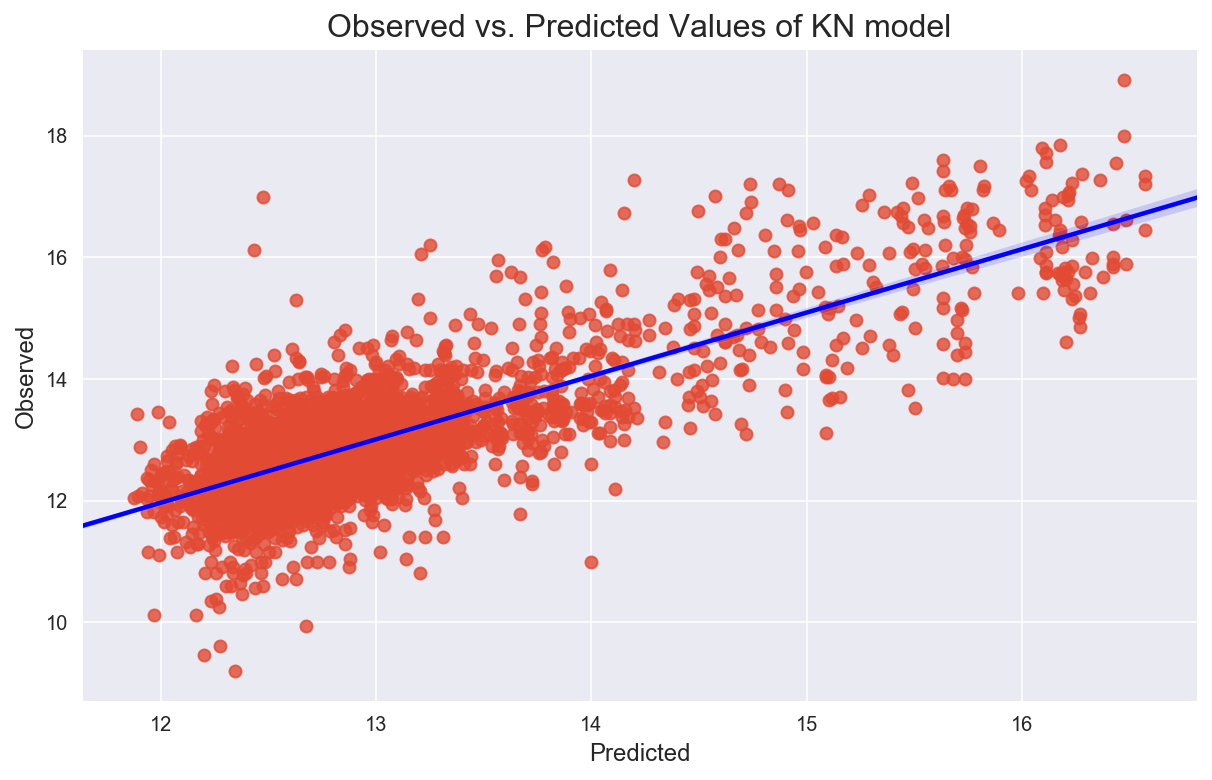

In [640]:
model_2 = neighbors.KNeighborsRegressor(25).fit(X_train, y_train)
fitted_vals = model_2.predict(X_test)
fig,ax = plt.subplots(1,1)
sns.regplot(x = fitted_vals, y = y_test, ax=ax, line_kws={'color': 'blue'})
ax.set_title('Observed vs. Predicted Values of KN model', fontsize=16)
ax.set(xlabel='Predicted', ylabel='Observed')

In [619]:
print('The MSE of the model is '+str(mean_squared_error(fitted_vals, y_test)))

The MSE of the model is 0.3456548536928076


## DecisionTree and SVR

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

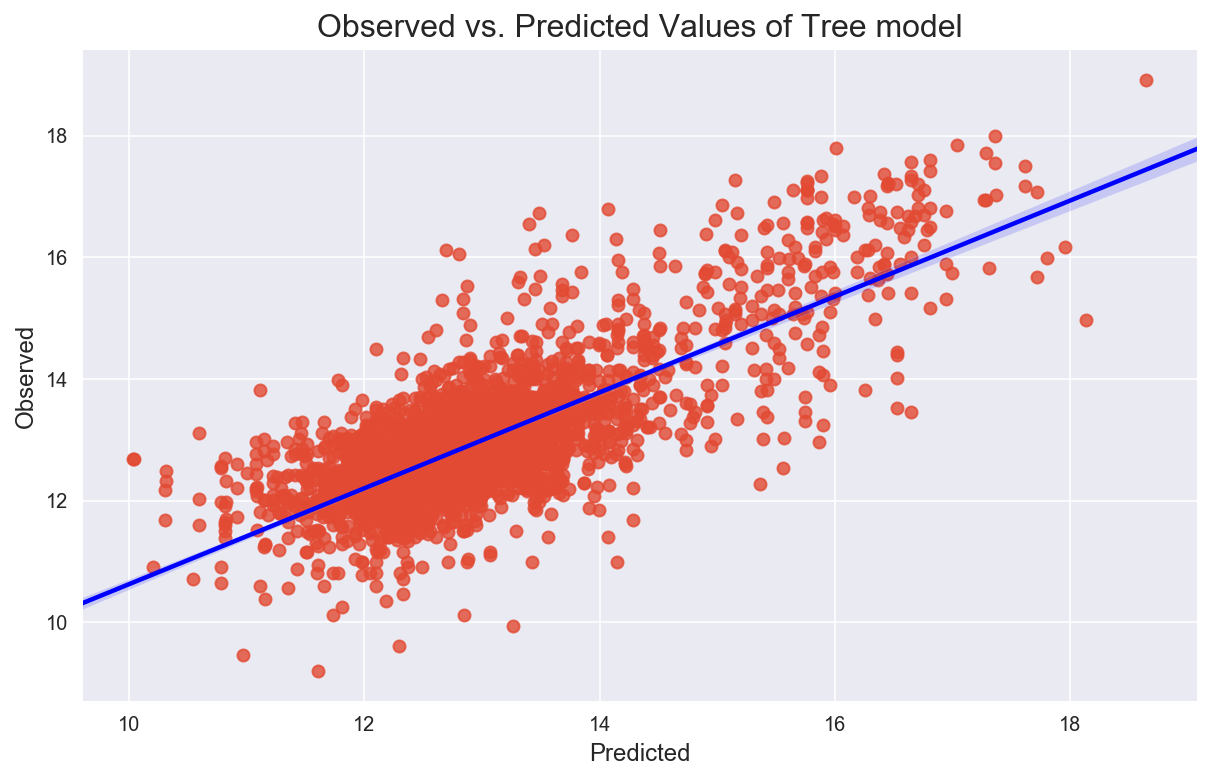

In [638]:
from sklearn import tree
from sklearn import svm
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
fitted_vals = clf.predict(X_test)

fig,ax = plt.subplots(1,1)
sns.regplot(x = fitted_vals, y = y_test, ax=ax, line_kws={'color': 'blue'})
ax.set_title('Observed vs. Predicted Values of Tree model', fontsize=16)
ax.set(xlabel='Predicted', ylabel='Observed')

In [635]:
print('The MSE of the model is '+str(mean_squared_error(fitted_vals, y_test)))

The MSE of the model is 0.42724765485508537


C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

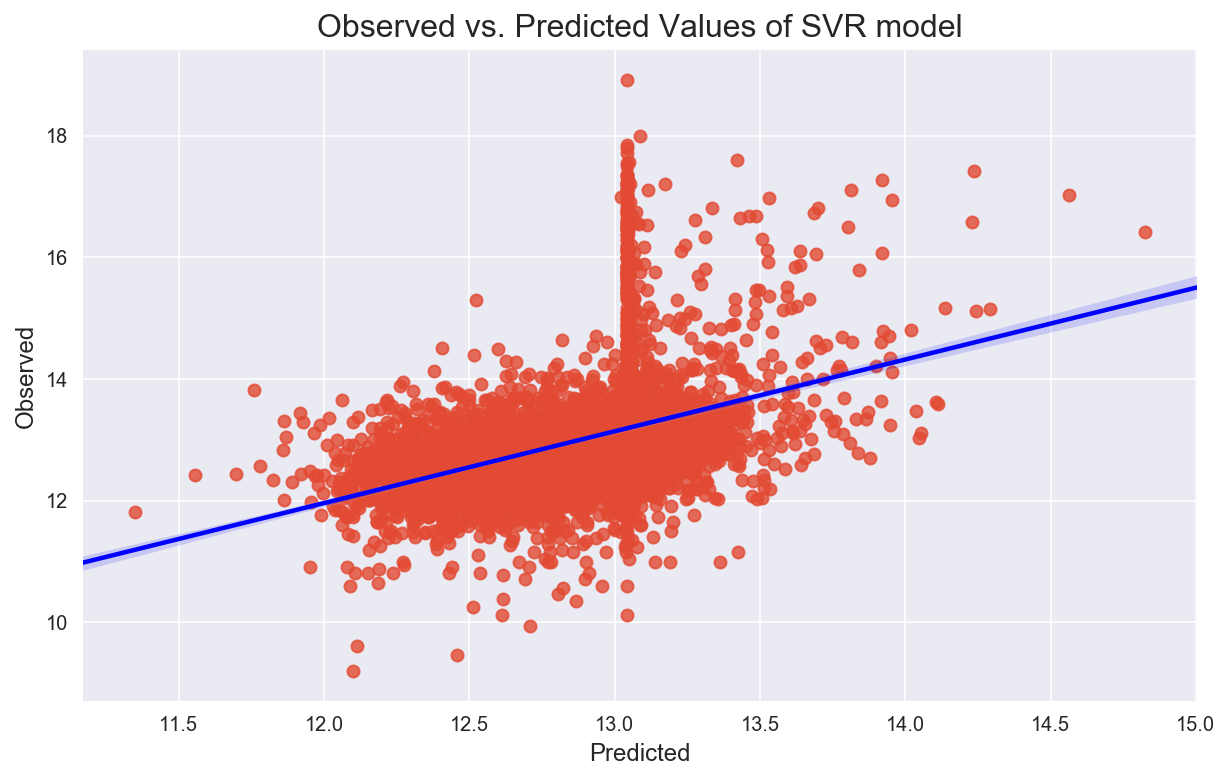

In [639]:
clf2 = svm.SVR()
clf2=clf2.fit(X_train, y_train)
fitted_vals2 = clf2.predict(X_test)
fig,ax = plt.subplots(1,1)
sns.regplot(x = fitted_vals2, y = y_test, ax=ax, line_kws={'color': 'blue'})
ax.set_title('Observed vs. Predicted Values of SVR model', fontsize=16)
ax.set(xlabel='Predicted', ylabel='Observed')

In [637]:
print('The MSE of the model is '+str(mean_squared_error(fitted_vals, y_test)))

The MSE of the model is 0.42724765485508537


For the last two model, we use the default parameter. We think they are not suitable in this case. The best model is still linear regression and it is also easy to explain

# Conclusion

In conclusion, according to the Zillow data, we know about the factors which can affect the price of houses. From the visualization part, we notice many interesting facts. we also find that the price of houses in CA and NY state are really high, while the rest of state is quite similar.

From model analysis part, we use four models to predict the price. The best one is linear model and our prediction is very close to the observed values. Though there are some warning for the linear model, we still conclude that our model is strong and meaningful.